In [10]:
## First let's load the training data
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from utils import butter_bandpass_filter, reshape_signal_into_windows
from scipy.stats import skew


## Training

### Data loading

In [11]:
ROOT_PATH = Path("train/")
training_data = [(np.load(ROOT_PATH / f"data_{i}.npy"),np.load(ROOT_PATH / f"target_{i}.npy")) for i in range(4)]

In [12]:
all_data = []
all_targets = []
for (data,target) in training_data:
    filtered_data =  butter_bandpass_filter(data,0.1,18,250,4)
    reshaped_data = reshape_signal_into_windows(filtered_data,250,2)
    targets_flatten = target[..., :len(reshaped_data[0])].reshape(-1)
    reshaped_data = reshaped_data.reshape((-1,reshaped_data.shape[-1]))
    all_data.append(reshaped_data)
    all_targets.append(targets_flatten)
all_data = np.concatenate(all_data)
all_targets = np.concatenate(all_targets)
assert all_data.shape[0] == all_targets.shape[0]


### Feature from the research paper : MMD

In [13]:
# MMD feature
# Nombre de sous-fenêtres
window_size = 100
num_windows = all_data.shape[-1] // window_size

# Initialiser un tableau pour stocker les distances
distances_2d = 0
# Calcul pour chaque sous-fenêtre
for i in range(num_windows):
    # Extraire les sous-fenêtres
    sub_window = all_data[..., i * window_size:(i + 1) * window_size]
    
    # Calcul des max, min, indices
    max_values = np.max(sub_window, axis=-1)
    min_values = np.min(sub_window, axis=-1)
    max_indices = np.argmax(sub_window, axis=-1)
    min_indices = np.argmin(sub_window, axis=-1)
    

    # Calcul des distances en 2D pour chaque sous-fenêtre
    distances_2d = distances_2d + np.sqrt((max_indices - min_indices)**2 + (max_values - min_values)**2)


### Other features computation

In [14]:
from scipy.fft import fft, ifft, fftshift
from scipy.stats import kurtosis
import pywt


# Example function to calculate wavelet features
def calculate_wavelet_energy(signal, wavelet='db4', level=4):
    """
    Compute the energy of the detail coefficients from discrete wavelet decomposition.
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Calculate the energy of detail coefficients
    energy_details = [np.sum(np.array(detail) ** 2) for detail in coeffs[1:]]  # Skip approximation
    return np.sum(energy_details)  # Return total energy of all details

# Apply wavelet feature calculation to each signal
wavelet = []
for signal in all_data:
    wavelet.append(calculate_wavelet_energy(signal))


mean_value = np.mean(all_data, axis=-1).reshape(-1)
std_dev = np.std(all_data, axis=-1).reshape(-1)
# We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
amplitude = (np.max(all_data,-1) - np.min(all_data,-1)).reshape(-1)


# Calcul de l'amplitude de la fenêtre précédente et suivante
amplitude_before = np.roll(amplitude, 1)  # Décalage vers le haut
amplitude_after = np.roll(amplitude, -1)  # Décalage vers le bas

# Gestion des valeurs en début et fin de série (pour éviter les valeurs erronées)
amplitude_before[0] = np.nan  # La première fenêtre n'a pas de fenêtre avant
amplitude_after[-1] = np.nan  # La dernière fenêtre n'a pas de fenêtre après

# Calculate kurtosis

training_data = pd.DataFrame({"amplitude":amplitude,
                              "mean_value": mean_value,
                              "std_dev": std_dev,
                              "amplitude_before": amplitude_before,
                              "amplitude_after": amplitude_after,
                              "distances_2d" : distances_2d,
                              "wavelet":wavelet,
                              "target":all_targets})

training_data = training_data.dropna()

### Train test split

In [15]:
# We train a model on 70% of the data and evaluate the model on the remaining 30%
prop_train = 0.70
n_train = int(prop_train * len(training_data))
train_set = training_data[:n_train]
val_set = training_data[n_train:]

### Cross Validation

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier


features = ["distances_2d", "amplitude", "mean_value", "std_dev", "amplitude_before", "amplitude_after", "wavelet"]

# Définition de la grille d'hyperparamètres


param_grid = {
    'n_estimators': [80, 100, 120, 150],          # Nombre d'arbres
    'max_depth': [4, 6, 8],           # Profondeur maximale
    'min_samples_split': [2, 3, 4],        # Nombre minimum d'échantillons pour diviser un nœud
}


# Création du modèle Random Forest
model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Configuration de la validation croisée
cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(cohen_kappa_score),
    cv=5,  # 5-fold cross-validation
    verbose=2,
    #n_jobs=-1
)

# Sélection des caractéristiques et de la cible
X_train = np.array(train_set[features])
y_train = train_set["target"]

# Entraînement avec GridSearchCV
cv.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres et du score associé
print("Best parameters found:", cv.best_params_)
print("Best Cohen Kappa score:", cv.best_score_)

# Évaluation du meilleur modèle sur l'ensemble de validation
best_model = cv.best_estimator_
X_val = np.array(val_set[features])
y_val = val_set["target"]

predictions = best_model.predict(X_val)
print("Cohen Kappa score on validation set:", cohen_kappa_score(y_val, predictions))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=80; total time=   7.2s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=80; total time=  10.5s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=80; total time=   6.5s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=80; total time=   5.6s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=80; total time=   4.0s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=120; total time=   4.6s
[CV] END .max_depth=4, min_samples_split=2, n_e

### Interpretability

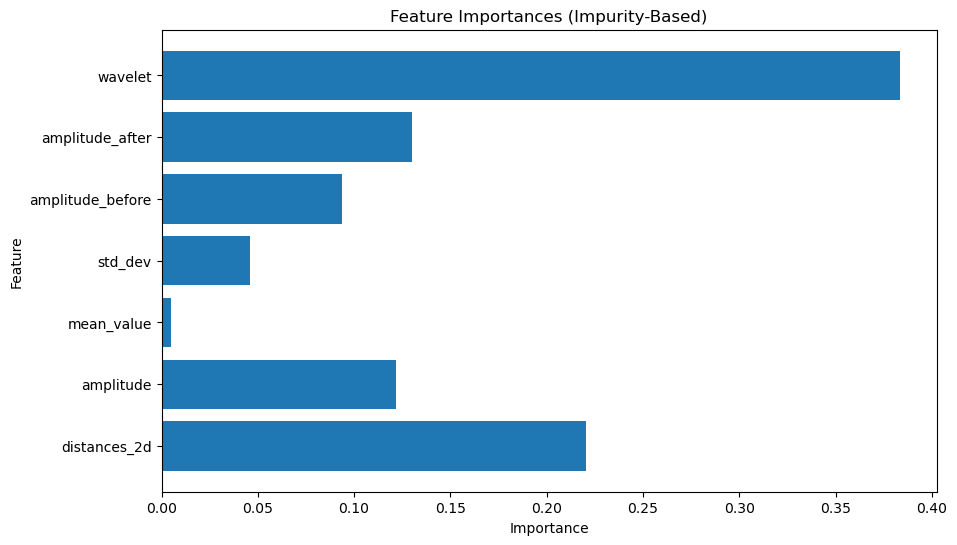

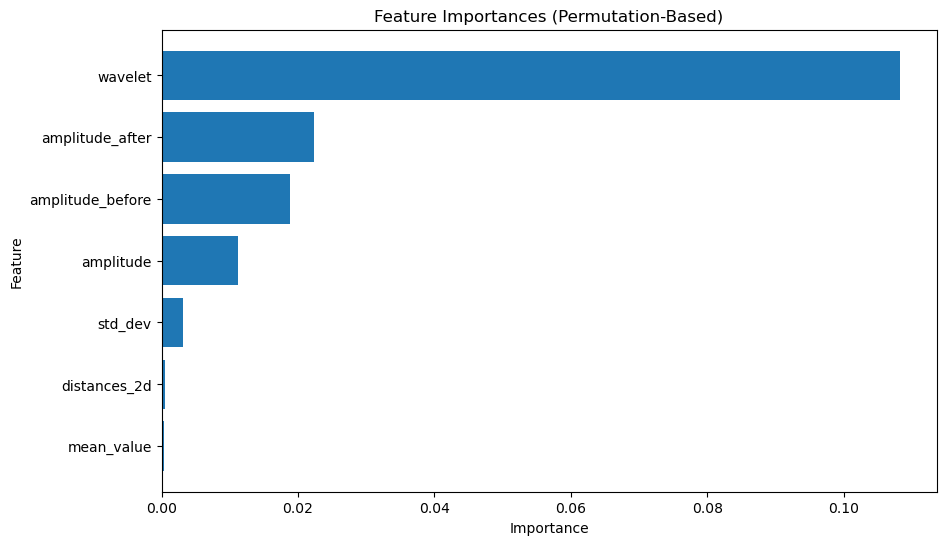

In [20]:
from sklearn.inspection import permutation_importance

# 1. Importance des caractéristiques - Basée sur l'impureté
feature_importances = best_model.feature_importances_
features = ["distances_2d", "amplitude", "mean_value", "std_dev", "amplitude_before", "amplitude_after", "wavelet"]

# Tracé des importances des caractéristiques (Impureté)
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Impurity-Based)')
plt.show()

# 2. Importance des caractéristiques - Permutation
perm_importance = permutation_importance(best_model, X_val, y_val, scoring='accuracy', n_repeats=10, random_state=42)
perm_sorted_idx = perm_importance.importances_mean.argsort()

# Tracé des importances des caractéristiques (Permutation)
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[perm_sorted_idx], perm_importance.importances_mean[perm_sorted_idx], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Permutation-Based)')
plt.show()



## Testing

In [21]:
ROOT_TEST_PATH = Path("test/")
test_data = {i:np.load(ROOT_TEST_PATH / f"data_{i}.npy") for i in [4,5]}
# We process each record independantly

def compute_features_on_record(data):
    """
    We compute each of the feature for each window and each channel
    Each value of the output dict has shape (Channels,T)
    """
    filtered_data =  butter_bandpass_filter(data,0.1,18,250,4)
    reshaped_data = reshape_signal_into_windows(filtered_data,250,2)

    mean_value = np.mean(reshaped_data, axis=-1)
    std_dev = np.std(reshaped_data, axis=-1)
    # We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
    amplitude = (np.max(reshaped_data,-1) - np.min(reshaped_data,-1))
    # Calcul de l'amplitude de la fenêtre précédente et suivante
    amplitude_before = np.roll(amplitude, 1)  # Décalage vers le haut
    amplitude_after = np.roll(amplitude, -1)  # Décalage vers le bas
    # Gestion des valeurs en début et fin de série (pour éviter les valeurs erronées)
    amplitude_before[0] = np.nan  # La première fenêtre n'a pas de fenêtre avant
    amplitude_after[-1] = np.nan  # La dernière fenêtre n'a pas de fenêtre après
    # Nombre de sous-fenêtres
    window_size = 100
    num_windows = reshaped_data.shape[-1] // window_size
    # Initialiser un tableau pour stocker les distances
    distances_2d = 0
    # Calcul pour chaque sous-fenêtre
    for i in range(num_windows):
        # Extraire les sous-fenêtres
        sub_window = reshaped_data[..., i * window_size:(i + 1) * window_size]
        
        # Calcul des max, min, indices
        max_values = np.max(sub_window, axis=-1)
        min_values = np.min(sub_window, axis=-1)
        max_indices = np.argmax(sub_window, axis=-1)
        min_indices = np.argmin(sub_window, axis=-1)
        # Calcul des distances en 2D pour chaque sous-fenêtre
        distances_2d = distances_2d + np.sqrt((max_indices - min_indices)**2 + (max_values - min_values)**2)

    
    wavelet = []
    for i in range(len(reshaped_data)): 
        wavelet_row= [] 
        for signal in reshaped_data[i]:
            wavelet_row.append(calculate_wavelet_energy(signal))
        wavelet.append(wavelet_row)
    wavelet = np.array(wavelet)

    return{"amplitude":amplitude,
                              "mean_value": mean_value,
                              "std_dev": std_dev,
                              "amplitude_before": amplitude_before,
                              "amplitude_after": amplitude_after,
                              "distances_2d" : distances_2d,
                              "wavelet":wavelet,
                              "target":all_targets}


def compute_predictions_on_record(data,model,features_name_for_model):
    predictions = []
    features = compute_features_on_record(data)
    features = np.array([features[k] for k in features_name_for_model]) 
    features = features.swapaxes(0,1).swapaxes(1,2)
    for channel in range(features.shape[0]):
        predictions.append(model.predict(features[channel]))
    return np.array(predictions)

def format_array_to_target_format(array, record_number):
    assert isinstance(record_number, int)
    assert isinstance(array, np.ndarray)
    assert len(array.shape) == 2
    assert array.shape[0] == 5
    assert set(np.unique(array)) == {0, 1}
    formatted_target = []
    for i in range(array.shape[0]):
        channel_encoding = (i + 1) * 100000
        record_number_encoding = record_number * 1000000
        for j in range(array.shape[1]):
            formatted_target.append(
                {
                    "identifier": record_number_encoding + channel_encoding + j,
                    "target": array[i, j],
                }
            )
    return formatted_target





In [22]:
results = []
for record_number, data in test_data.items():
    preds = compute_predictions_on_record(data, best_model,features)
    formatted_preds = format_array_to_target_format(preds,record_number)
    results.extend(formatted_preds)
df = pd.DataFrame(results)
df.to_csv("submission.csv",index = False)